In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
model = ResNet50()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [3]:
features = {}
directory = "C:\\Users\\vedur\\OneDrive\\Desktop\\Projects\\Image Caption Generator\\Images"
for img_name in tqdm(os.listdir(directory)):
  img_path = directory + '/' + img_name
  image = load_img(img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = model.predict(image, verbose=0)
  image_id = img_name.split('.')[0]
  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [4]:
pickle.dump(features, open(os.path.join("C:\\Users\\vedur\\OneDrive\\Desktop\\Projects\\Image Caption Generator", "features.pkl"), "wb"))

In [5]:
with open(os.path.join("C:\\Users\\vedur\\OneDrive\\Desktop\\Projects\\Image Caption Generator", "features.pkl"), "rb") as f:
    features = pickle.load(f)

In [6]:
with open("C:\\Users\\vedur\\OneDrive\\Desktop\\Projects\\Image Caption Generator\\captions.txt", "r") as f:
    next(f)
    captions_doc = f.read()

In [7]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
  tokens = line.split()
  if len(line) < 2:
    continue
  img_id, caption = tokens[0], tokens[1:]
  img_id = img_id.split('.')[0]
  caption = ' '.join(caption)
  if img_id not in mapping:
    mapping[img_id] = []
  mapping[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mapping)

8091

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [10]:
mapping['667626_18933d713e']

['girl is stretched out in shallow water',
 'girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'little girl in a red swimsuit is laying on her back in shallow water .',
 'young girl is lying in the sand , while ocean water is surrounding her ."',
 'wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [11]:
clean(mapping)

In [12]:
mapping['667626_18933d713e']

['startseq girl is stretched out in shallow water endseq',
 'startseq girl wearing red and multi-colored bikini is laying on her back in shallow water endseq',
 'startseq little girl in red swimsuit is laying on her back in shallow water endseq',
 'startseq young girl is lying in the sand while ocean water is surrounding her ." endseq',
 'startseq wearing bikini lying on her back in shallow pool of clear blue water endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq dogs of different breeds looking at each other on the road endseq',
 'startseq dogs on pavement moving toward each other endseq']

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8404

In [18]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [21]:
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [22]:
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1070s 9s/step - loss: 6.2316
113/113 ━━━━━━━━━━━━━━━━━━━━ 530s 5s/step - loss: 4.5458
113/113 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - loss: 3.9241
113/113 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - loss: 3.6129
113/113 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - loss: 3.3996
113/113 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - loss: 3.2394
113/113 ━━━━━━━━━━━━━━━━━━━━ 630s 6s/step - loss: 3.1101
113/113 ━━━━━━━━━━━━━━━━━━━━ 687s 6s/step - loss: 3.0066
113/113 ━━━━━━━━━━━━━━━━━━━━ 639s 6s/step - loss: 2.9165
113/113 ━━━━━━━━━━━━━━━━━━━━ 681s 6s/step - loss: 2.8369
113/113 ━━━━━━━━━━━━━━━━━━━━ 736s 7s/step - loss: 2.7668
113/113 ━━━━━━━━━━━━━━━━━━━━ 573s 5s/step - loss: 2.7073
113/113 ━━━━━━━━━━━━━━━━━━━━ 571s 5s/step - loss: 2.6598
113/113 ━━━━━━━━━━━━━━━━━━━━ 744s 7s/step - loss: 2.6111
113/113 ━━━━━━━━━━━━━━━━━━━━ 766s 7s/step - loss: 2.5709


In [23]:
model.save("C:\\Users\\vedur\\OneDrive\\Desktop\\Projects\\Image Caption Generator\\model.h5")

In [24]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [25]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [26]:
! pip install nltk
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.586641
BLEU-2: 0.366298


In [27]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "49553964_cee950f3ba.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("C:\\Users\\vedur\\OneDrive\\Desktop\\Projects\\Image Caption Generator\\Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq on skis looking at artwork for sale in the snow endseq


--------------------Predicted--------------------
startseq people are walking through the snow endseq


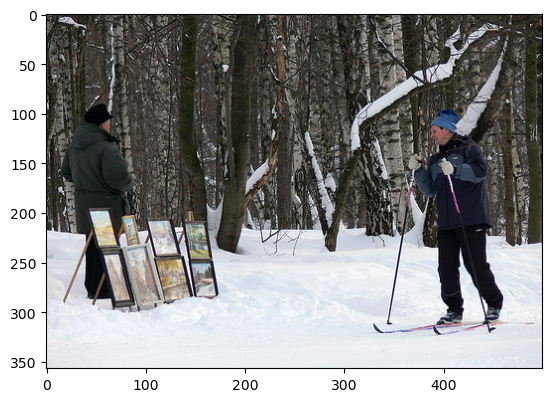

In [28]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq couple watches boat against skyline endseq
startseq man and woman sit on bench watching boat go by ." endseq
startseq sun is setting while man and woman watch boat go by endseq
startseq people sit on bench and watch boat on the water endseq
startseq people watching boat sail past endseq
--------------------Predicted--------------------
startseq people are sitting on the end of dock endseq


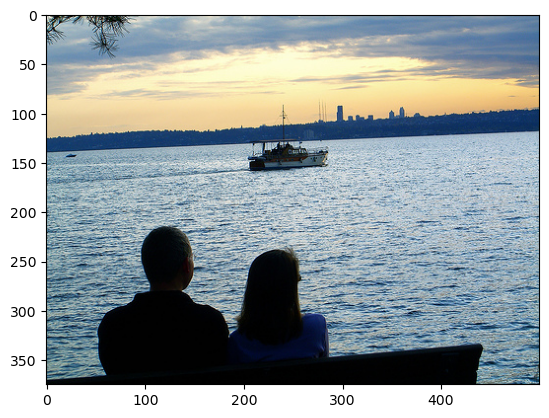

In [31]:
generate_caption("44129946_9eeb385d77.jpg")

---------------------Actual---------------------
startseq boy in yellow is riding scooter on the street endseq
startseq boy on scooter endseq
startseq boy wearing helmet rides scooter in suburban neighborhood endseq
startseq child on scooter is jumping the curb endseq
startseq young boy wearing an orange helmet riding scooter endseq
--------------------Predicted--------------------
startseq man is performing trick on skateboard endseq


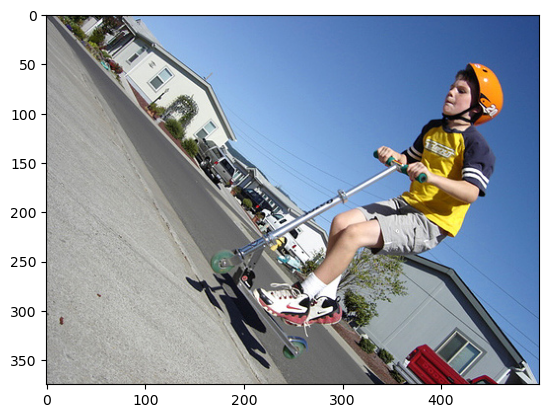

In [30]:
generate_caption("47870024_73a4481f7d.jpg")